# This notebook is a test bench for working on the core model

In [1]:
import torch
import numpy as np
from torch import nn

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms

from tqdm import tqdm
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Dict

from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import gc

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [4]:
def lp_distance(X, Y, p=2):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [5]:
def cosine_distance(X, Y):
    """
    Computes the rowwise cosine distance between matrices X and Y.
    """
    dots = torch.stack([torch.dot(xi, yi) for xi, yi in zip(X, Y)])
    norms = torch.stack([torch.dot(xi.unsqueeze(0), yi.unsqueeze(0)) for xi, yi in zip(torch.norm(X, dim=1), torch.norm(Y, dim=1))])
    cos_sim = torch.div(dots, norms)
    return 1.0 - cos_sim

In [6]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [7]:
def mean_sparsity(X):
    """
    Computes the mean of the row-wise sparsity of the input feature-matrix X
    """
    return np.mean(np.count_nonzero(X, axis=1) / X.shape[1])

In [8]:
from dataclasses import dataclass
from transformers.file_utils import ModelOutput

@dataclass
class ClusterOutput(ModelOutput):
    
    loss: torch.FloatTensor = None
    predicted_labels: torch.IntTensor = None
    embeddings: torch.FloatTensor = None

In [9]:
def cls_embedding_extractor(model_output: ModelOutput):
    return model_output.last_hidden_state[:, 0, :].float()

def meanpooler_embedding_extractor(model_ouput: ModelOutput):
    return model_ouput.last_hidden_state.mean(dim=1).float()

def concat_cls_n_hidden_states(model_output: ModelOutput, n=3):
    n_hidden_states = model_output.hidden_states[-n:]
    return torch.cat([t[:, 0, :] for t in n_hidden_states], 1).float()

def concat_mean_n_hidden_states(model_output: ModelOutput, n=3):
    n_hidden_states = model_output.hidden_states[-n:]
    return torch.cat([t.mean(dim=1) for t in n_hidden_states], 1).float()

In [10]:
class ClusterLM(nn.Module):

    def __init__(self,
                 initial_centroids: torch.tensor,
                 lm_model,
                 tokenizer,
                 metric=lp_distance,
                 embedding_extractor=cls_embedding_extractor,
                 do_language_modeling=True,
                 device='cpu'
                 ):
        super(ClusterLM, self).__init__()

        self.initial_centroids = initial_centroids

        self.add_module('lm_model', lm_model)
        self.register_parameter('centroids', nn.Parameter(initial_centroids.clone().float(), requires_grad=True))

        self.tokenizer = tokenizer
        self.metric = metric
        self.embedding_extractor = embedding_extractor
        self.do_language_modeling = do_language_modeling
        self.device = device

        self.to(self.device)

    def forward(self, texts, alpha=1.0):
        """
        Input: texts and labels (optional)
        Returns: lm_language modelling output, own output dict (clustering_loss, predicted_labels)
        """
        # Language Modeling Part:

        lm_outputs = ModelOutput(loss=torch.tensor(0.0, requires_grad=True).to(self.device))

        if self.do_language_modeling:
            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True)

            input_ids = inputs['input_ids'].clone()
            input_ids, true_ids = mask_tokens(input_ids, self.tokenizer)
            inputs['input_ids'] = input_ids

            inputs = inputs.to(self.device)
            true_ids = true_ids.to(self.device)
            lm_outputs = self.lm_model(labels=true_ids, **inputs)

        # Clustering Part:
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True)

        inputs.to(self.device)

        # 0. Obtain embeddings for each input
        input_embeddings = self.embedding_extractor(self.lm_model.base_model(**inputs))
        
        # 1. Compute distances from each input embedding to each centroids
        distances = torch.stack([self.metric(embedding.unsqueeze(0), self.centroids) for embedding in input_embeddings])
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)  # => shape (n_centroids, n_samples)

        # 2. Compute the paramterized softmin for each centroid of each distance to each centroid per input sample
        # Find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        # Compute exponetials
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        # Compute softmin
        softmin = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. Weight the distance between each sample and each centroid
        weighted_distances = distances * softmin

        # 4. Sum over weighted_distances to obtain loss
        clustering_loss = weighted_distances.sum(dim=1).mean()

        # Create clustering output dictionary
        cluster_outputs = ClusterOutput(
            loss=clustering_loss,
            predicted_labels=nearest_centroids.long(),
            embeddings=input_embeddings.cpu().detach()
        )

        return lm_outputs, cluster_outputs


In [11]:
def init_model(
    lm_model,
    tokenizer,
    data_loader,
    n_clusters,
    embedding_extractor=concat_cls_n_hidden_states,
    device='cpu',
    random_state=np.random.RandomState(42),
    **kwargs,
):
    
    initial_embeddings = []
    for batch_texts, _ in data_loader:
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
        inputs = inputs.to(device)
        outputs = lm_model.base_model(**inputs)
        extracted_embeddings = embedding_extractor(outputs).cpu().detach().numpy()
        initial_embeddings.append(extracted_embeddings)
        
    initial_embeddings = np.vstack(initial_embeddings)
    
    
    initial_centroids = _k_init(
        initial_embeddings,
        n_clusters=np.unique(labels).shape[0],
        x_squared_norms=row_norms(initial_embeddings, squared=True),
        random_state=np.random.RandomState(42)
    )
    
    model = ClusterLM(
        lm_model=lm_model,
        tokenizer=tokenizer,
        embedding_extractor=embedding_extractor,
        initial_centroids=torch.from_numpy(initial_centroids),
        device=device,
        **kwargs
    )
    
    return model, initial_centroids, initial_embeddings

In [12]:
def evaluate(model, eval_data_loader, verbose=True):
    model.eval()
    true_labels = []
    predicted_labels = []
    eval_data_it = tqdm(eval_data_loader, desc='Eval') if verbose else eval_data_loader
    for batch_texts, batch_labels in eval_data_it:
        true_labels.extend(batch_labels.numpy().astype('int'))
        _, cluster_outputs = model(texts=list(batch_texts))
        predicted_labels.extend(cluster_outputs.predicted_labels.numpy().astype('int'))
    
    return np.array(predicted_labels), np.array(true_labels)

In [13]:
@dataclass
class TrainHistory:
    clustering_losses: List[float] 
    lm_losses: List[float]
    combined_losses: List[float]
    prediction_history: List[np.array]
    eval_hist: List[Dict[str, float]]
    

In [14]:
def train(
    n_epochs,
    model,
    optimizer,
    scheduler,
    annealing_alphas,
    train_data_loader,
    eval_data_loader=None,
    do_eval=True,
    clustering_loss_weight=0.5,
    metrics=(cluster_accuracy, adjusted_rand_score, normalized_mutual_info_score),
    verbose=True
):
    
    total_clustering_losses = []
    total_lm_losses = []
    total_combined_losses = []
    prediction_history = []
    eval_hist = []
    
    assert len(annealing_alphas) >= n_epochs
    for epoch, alpha in zip(range(n_epochs), annealing_alphas):
        model.train()
        train_data_it = tqdm(train_data_loader, desc='Train') if verbose else train_data_loader
        for batch_texts, _ in train_data_it:
            lm_outputs, cluster_outputs = model(texts=list(batch_texts), alpha=alpha)
            combined_loss = lm_outputs.loss + (clustering_loss_weight * cluster_outputs.loss)
            
        
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_clustering_losses.append(cluster_outputs.loss.item())
            total_lm_losses.append(lm_outputs.loss.item())
            total_combined_losses.append(combined_loss.item())
            
            if verbose:
                train_data_it.set_description(
                    f'Epoch: {epoch} | CombLoss: {combined_loss.item()} |LMLoss: {lm_outputs.loss.item()} | ' \
                    f' ClusterLoss: {cluster_outputs.loss.item()} | LR: {scheduler.get_last_lr()[0]} | Alpha: {alpha}'
                )
            
            
        if do_eval:
            if eval_data_loader is None:
                eval_data_loader = train_data_it if not verbose else train_data_it.iterable
            
            predicted_labels, true_labels = evaluate(
                model=model,
                eval_data_loader=eval_data_loader,
                verbose=verbose)
            
            prediction_history.append(deepcopy(predicted_labels))
            
            m = {}
            for metric in metrics:
                value = metric(true_labels, predicted_labels)
                m[metric.__name__] = value
                print(f'{metric.__name__}: {value}')
            eval_hist.append(m)
    
    train_history = TrainHistory(
        clustering_losses=total_clustering_losses,
        lm_losses=total_lm_losses,
        combined_losses=total_combined_losses,
        prediction_history=prediction_history,
        eval_hist=eval_hist
    )
    return train_history    

In [15]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [16]:
# Test params 
N_EPOCHS = 8
DEVICE = 'cuda:0'

EMBEDDING_EXTRACTOR = concat_cls_n_hidden_states

In [17]:
import pandas as pd
df = pd.read_csv('datasets/ag_news_subset5.csv')

texts = df['texts'].to_numpy()
labels = df['labels'].to_numpy()

In [18]:
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('ag_news_subset', split='train', shuffle_files=True)
#test_ds = tfds.load('ag_news_subset', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['description'], example['label']
#        texts.append(text.decode("utf-8"))
#        labels.append(label)
#
#labels = np.array(labels)
#
#del train_ds
#del test_ds

In [19]:
from sklearn.model_selection import train_test_split
texts, _, labels, _ = train_test_split(texts, labels, stratify=labels, test_size=0.95, random_state=42)

In [20]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False) # batch size bigger => results better
# 16 for distilbert | 8 for bert-base

In [21]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from transformers import ElectraTokenizer, ElectraForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import XLNetTokenizer, XLNetLMHeadModel

import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)
#lm_model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)

#tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)
#lm_model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)


#tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", return_dict=True, output_hidden_states=True)
#lm_model = XLNetLMHeadModel.from_pretrained("xlnet-base-cased", return_dict=True, mem_len=1024, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-uncased-ag-news", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("allenai/news_roberta_base")
#lm_model = AutoModelForMaskedLM.from_pretrained("allenai/news_roberta_base", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
#lm_model = AutoModelForMaskedLM.from_pretrained("prajjwal1/bert-small", return_dict=True, output_hidden_states=True)


lm_model.to(DEVICE)

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [22]:
constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
alphas = np.zeros(N_EPOCHS, dtype=float)
alphas[0] = 0.1
for i in range(1, N_EPOCHS):
    alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
annealing_alphas = alphas / constant_value
#annealing_alphas = np.ones(N_EPOCHS) * 1000.0
annealing_alphas = np.arange(1, N_EPOCHS+1).astype('float')

In [23]:
model, initial_centroids, initial_embeddings = init_model(
    lm_model=lm_model,
    tokenizer=tokenizer,
    data_loader=data_loader,
    embedding_extractor=EMBEDDING_EXTRACTOR,
    n_clusters=np.unique(labels).shape[0],
    device=DEVICE
)

In [24]:
from tqdm import tqdm
import numpy as np
from transformers import (
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup
)

# RMSprop
# or Adam(W)???
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=2e-5, #2e-5, 5e-7, 
    eps=1e-8
)

total_steps = len(data_loader) * N_EPOCHS

#scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#    optimizer=opt,
#    num_warmup_steps=int(len(data_loader)*0.5),
#    num_training_steps=total_steps,
#    num_cycles=N_EPOCHS//2
#)

scheduler = get_linear_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=int(len(data_loader)*0.5),
    num_training_steps=total_steps
)


In [25]:
hist = train(
    n_epochs=N_EPOCHS,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    annealing_alphas=annealing_alphas,
    train_data_loader=data_loader,
    verbose=True
)

Epoch: 0 | CombLoss: 8.481732368469238 |LMLoss: 3.464989423751831 |  ClusterLoss: 10.033485412597656 | LR: 1.866666666666667e-05 | Alpha: 1.0: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]  
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.59it/s]
Epoch: 1 | CombLoss: 6.87879753112793 |LMLoss: 2.1290504932403564 |  ClusterLoss: 9.499493598937988 | LR: 1.8533333333333334e-05 | Alpha: 2.0:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7554858934169278)
adjusted_rand_score: 0.5242143731911221
normalized_mutual_info_score: 0.5432609103064678


Epoch: 1 | CombLoss: 7.03053092956543 |LMLoss: 2.3591573238372803 |  ClusterLoss: 9.34274673461914 | LR: 1.6000000000000003e-05 | Alpha: 2.0: 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]   
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.60it/s]
Epoch: 2 | CombLoss: 6.635511875152588 |LMLoss: 2.551128387451172 |  ClusterLoss: 8.168766975402832 | LR: 1.586666666666667e-05 | Alpha: 3.0:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7648902821316614)
adjusted_rand_score: 0.5357085788099678
normalized_mutual_info_score: 0.544944281155989


Epoch: 2 | CombLoss: 6.877229690551758 |LMLoss: 2.6208102703094482 |  ClusterLoss: 8.512838363647461 | LR: 1.3333333333333333e-05 | Alpha: 3.0: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s] 
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.56it/s]
Epoch: 3 | CombLoss: 6.427374839782715 |LMLoss: 2.9217588901519775 |  ClusterLoss: 7.011232376098633 | LR: 1.3200000000000002e-05 | Alpha: 4.0:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7648902821316614)
adjusted_rand_score: 0.5281826918664404
normalized_mutual_info_score: 0.5311378772046162


Epoch: 3 | CombLoss: 6.716196537017822 |LMLoss: 2.530399799346924 |  ClusterLoss: 8.371593475341797 | LR: 1.0666666666666667e-05 | Alpha: 4.0: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]  
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.50it/s]
Epoch: 4 | CombLoss: 6.140011787414551 |LMLoss: 2.638695001602173 |  ClusterLoss: 7.002633094787598 | LR: 1.0533333333333333e-05 | Alpha: 5.0:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.774294670846395)
adjusted_rand_score: 0.5414690996754213
normalized_mutual_info_score: 0.5427853148135602


Epoch: 4 | CombLoss: 6.860774040222168 |LMLoss: 2.90800404548645 |  ClusterLoss: 7.9055399894714355 | LR: 8.000000000000001e-06 | Alpha: 5.0: 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]  
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.49it/s]
Epoch: 5 | CombLoss: 5.47779655456543 |LMLoss: 2.3046212196350098 |  ClusterLoss: 6.34635066986084 | LR: 7.866666666666667e-06 | Alpha: 6.0:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7774294670846394)
adjusted_rand_score: 0.542362661781825
normalized_mutual_info_score: 0.5453352518145141


Epoch: 5 | CombLoss: 6.492974281311035 |LMLoss: 2.742860794067383 |  ClusterLoss: 7.500227451324463 | LR: 5.333333333333334e-06 | Alpha: 6.0: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s]  
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.40it/s]
Epoch: 6 | CombLoss: 5.734677314758301 |LMLoss: 2.4932405948638916 |  ClusterLoss: 6.482873439788818 | LR: 5.2e-06 | Alpha: 7.0:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7711598746081505)
adjusted_rand_score: 0.5380875932319251
normalized_mutual_info_score: 0.5445396054895599


Epoch: 6 | CombLoss: 6.55558967590332 |LMLoss: 2.8158109188079834 |  ClusterLoss: 7.479557037353516 | LR: 2.666666666666667e-06 | Alpha: 7.0: 100%|██████████| 20/20 [00:02<00:00,  6.96it/s]   
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.33it/s]
Epoch: 7 | CombLoss: 5.77659273147583 |LMLoss: 2.570863962173462 |  ClusterLoss: 6.411457538604736 | LR: 2.5333333333333338e-06 | Alpha: 8.0:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7711598746081505)
adjusted_rand_score: 0.5361493220544918
normalized_mutual_info_score: 0.5421704825402894


Epoch: 7 | CombLoss: 5.7255706787109375 |LMLoss: 2.057229995727539 |  ClusterLoss: 7.336680889129639 | LR: 0.0 | Alpha: 8.0: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]                   
Eval: 100%|██████████| 20/20 [00:01<00:00, 19.30it/s]

cluster_accuracy: ({0: 1, 1: 2, 2: 0, 3: 3}, 0.7617554858934169)
adjusted_rand_score: 0.5269509478557766
normalized_mutual_info_score: 0.5348420974476511


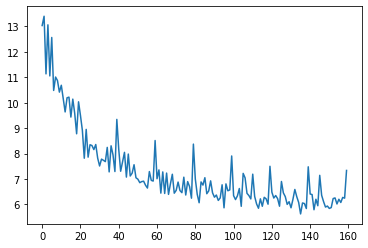

In [26]:
plt.plot(hist.clustering_losses)
plt.show()

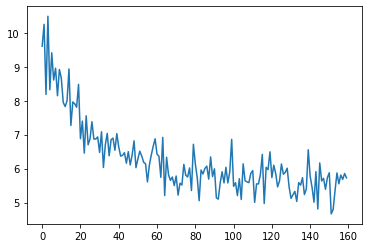

In [27]:
plt.plot(hist.combined_losses)
plt.show()

In [28]:
[i['cluster_accuracy'][0] for i in hist.eval_hist]

[{0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3},
 {0: 1, 1: 2, 2: 0, 3: 3}]

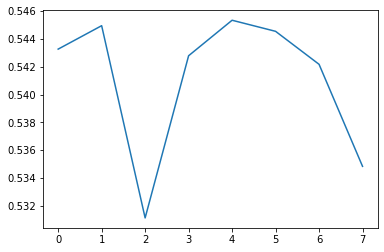

In [29]:
plt.plot([i['normalized_mutual_info_score'] for i in hist.eval_hist])
plt.show()

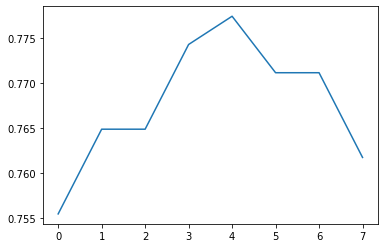

In [30]:
plt.plot([i['cluster_accuracy'][1] for i in hist.eval_hist])
plt.show()

In [31]:
import pickle
with open('train_results_test.h', 'wb') as f:
    pickle.dump(hist, file=f)

In [32]:
del tokenizer
del scheduler
del opt
del model

In [33]:
gc.collect()

11336

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()